In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bbc-fulltext-and-category/bbc-text.csv
/kaggle/input/arabic-dialect/final_csv_trial.csv
/kaggle/input/arabic-dialect/final_csv_trial1.csv
/kaggle/input/arabic-dialect/responses.csv
/kaggle/input/arabic-dialect/__notebook_source__.ipynb


In [ ]:
# ========================================
# library
# ========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, KFold,GroupKFold
from sklearn.metrics import mean_squared_error
%matplotlib inline

from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from tqdm import tqdm, trange
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import random
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import BertTokenizer,BertForSequenceClassification, AdamW, BertConfig,XLNetTokenizer, XLNetForSequenceClassification,XLNetLMHeadModel
from transformers import get_linear_schedule_with_warmup
import transformers
from transformers import XLNetModel,XLNetTokenizer,XLNetConfig
from transformers import BartModel,BertModel,BertTokenizer
from transformers import get_linear_schedule_with_warmup
import time
import datetime

In [ ]:
import pyarabic.araby as ar

import re , emoji, functools, operator, string
import torch , optuna, gc, random, os

import pandas as pd
import numpy as np
import nltk 
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from textblob import Word
import re

#importing scikit learn library

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

In [ ]:
# ==================
# Constants & Configurations
# ==================

epochs = 3
batch_size=30
max_len=100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Bert_Model='UBC-NLP/MARBERT'


#bashar-talafha/multi-dialect-bert-base-arabic


#Tokenizer
bert_tokenizer = BertTokenizer.from_pretrained(Bert_Model, do_lower_case=True)


#Transformer Models
bert_model = BertForSequenceClassification.from_pretrained(
Bert_Model, # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 18, # The number of output labels  
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

bert_model.cuda() # Tell pytorch to run this model on the GPU.

#Model Parameters
bert_params = list(bert_model.named_parameters())

#Optimizer
bert_optimizer = AdamW(bert_model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, 
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )





Downloading:   0%|          | 0.00/1.05M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/376 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/701 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/624M [00:00<?, ?B/s]

Some weights of the model checkpoint at UBC-NLP/MARBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at U

In [ ]:
# Check If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


# Basic EDA & Data Preparation

In [ ]:
df = pd.read_csv('../input/arabic-dialect/final_csv_trial.csv',lineterminator='\n')
df.tail()

,id,dialect,text
458192,1019484980282580992,BH,@Al_mhbaa_7 مبسوطين منك اللي باسطانا😅
458193,1021083283709407232,BH,@Zzainabali @P_ameerah والله ماينده ابش يختي
458194,1017477537889431552,BH,@Al_mhbaa_7 شو عملنا لك حنا تهربي مننا احنا مس...
458195,1022430374696239232,BH,@haneenalmwla الله يبارك فيها وبالعافيه 😋😋😋
458196,1022409931029458944,BH,@jolnar121 السحله ضيفي ي بتطلع لك سحليه😅😅


In [ ]:

nltk.download("stopwords")
arb_stopwords = set(nltk.corpus.stopwords.words("arabic"))
import re

import nltk

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


def remove_users(df, col):
    df[col] = df[col].apply(lambda x: re.sub(r'(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', str(x))) # remove re-tweet
    df[col] = df[col].apply(lambda x: re.sub(r'(@[A-Za-z0-9-_]+)', '', str(x))) # remove tweeted at
    df[col] = df[col].apply(lambda x: re.sub(r'@[^\s]+[\s]?', '', str(x)))

def remove_special_char(df, col):
    df[col] = df[col].apply(lambda x: re.sub(r'&[\S]+?;', '', str(x)))
    df[col] = df[col].apply(lambda x: re.sub(r'[^\w\s]', r'', str(x)))
    df[col] = df[col].apply(lambda x: re.sub(r'#', ' ', str(x)))

def remove_links(df, col):
    df[col] = df[col].apply(lambda x: re.sub(r'http\S+', '', str(x)))  # remove http links
    df[col] = df[col].apply(lambda x: re.sub(r'bit.ly/\S+', '', str(x)))  # remove bit.ly links    

def remove_numerics(df, col):
    """function to remove numbers or words with digits"""
    df[col] = df[col].apply(lambda x: re.sub(r'\w*\d\w*', r'', str(x)))

def remove_whitespaces(df, col):
    """function to remove any double or more whitespaces to single and any leading and trailing whitespaces"""
    df[col] = df[col].apply(lambda x: re.sub(r'\s\s+', ' ', str(x))) 
    df[col] = df[col].apply(lambda x: re.sub(r'(\A\s+|\s+\Z)', '', str(x))) 

def lemmatize(token):
    """Returns lemmatization of a token"""
    return WordNetLemmatizer().lemmatize(token, pos='v')

def tokenize(tweet):
    """Returns tokenized representation of words in lemma form excluding stopwords"""
    result = []
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(tweet)
    for token in word_tokens:    
        if token.lower not in stop_words and len(token) > 2:  # drops words with less than 3 characters
            result.append(lemmatize(token))
    return result


def preprocess_tweets(df, col):
    """master function to preprocess tweets"""
    remove_users(df, col)
    remove_links(df, col)
    remove_special_char(df, col)
    remove_whitespaces(df, col)
    remove_numerics(df, col)
    #tokenize_and_lemmatize(df, col)
    return df


def preprocess(tweet):
    result = re.sub(r'(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)
    result = re.sub(r'(@[A-Za-z0-9-_]+)', '', result)
    result = re.sub(r'http\S+', '', result)
    result = re.sub(r'bit.ly/\S+', '', result)
    # result = re.sub(r'(.)\1+', r'\1\1', result)
    result = " ".join(re.findall('[A-Z][^A-Z]*', result)) 
    result = re.sub(r'&[\S]+?;', '', result)
    result = re.sub(r'#', ' ', result)
    result = re.sub(r'[^\w\s]', r'', result)    
    result = re.sub(r'\w*\d\w*', r'', result)
    result = re.sub(r'\s\s+', ' ', result)
    result = re.sub(r'(\A\s+|\s+\Z)', '', result)
    result = tokenize(result)
    return list(result)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
preprocess_tweets(df, 'text')
df

,id,dialect,text
0,1175358310087892992,IQ,لكن بالنهاية ينتفض يغير
1,1175416117793349632,IQ,يعني هذا محسوب على البشر حيونه ووحشيه وتطلبون ...
2,1175450108898565888,IQ,مبين من كلامه خليجي
3,1175471073770573824,IQ,يسلملي مرورك وروحك الحلوه
4,1175496913145217024,IQ,وين هل الغيبه اخ محمد
...,...,...,...
458192,1019484980282580992,BH,مبسوطين منك اللي باسطانا
458193,1021083283709407232,BH,والله ماينده ابش يختي
458194,1017477537889431552,BH,شو عملنا لك حنا تهربي مننا احنا مساكين ليش بتع...
458195,1022430374696239232,BH,الله يبارك فيها وبالعافيه


### Label Encoder 

In [ ]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
df['label'] = enc.fit_transform(df['dialect'])

class_names = df.groupby(['dialect', 'label']).count().reset_index().loc[:,['dialect', 'label']]

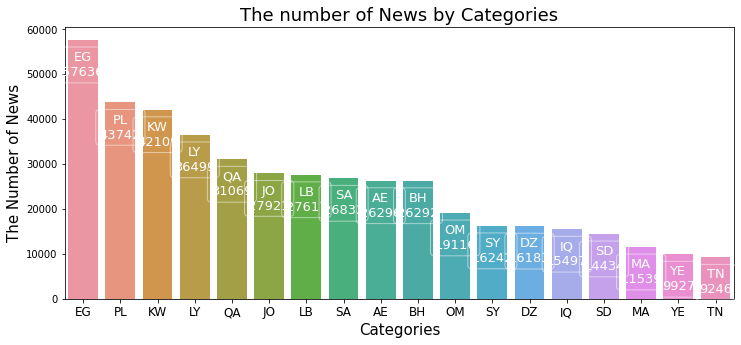

In [ ]:
category_counts = df['dialect'].value_counts()
categories = category_counts.index

fig = plt.figure(figsize = (12,5))
ax = fig.add_subplot(111)
sns.barplot(x = category_counts.index , y = category_counts)
for a, p in enumerate(ax.patches):
    ax.annotate(f'{categories[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )
plt.xlabel('Categories', size = 15)
plt.ylabel('The Number of News', size= 15)
plt.xticks(size = 12)

plt.title("The number of News by Categories" , size = 18)
plt.show()

### Split Data into Train / Test :

In [ ]:
## Set random seed 
seed = 42
np.random.seed(seed) 

## Shuffle Data
def shuffle(df, n=3, axis=0):     
    df = df.copy()
    random_states = [2,42,4]
    for i in range(n):
        df = df.sample(frac=1,random_state=random_states[i])
    return df

new_df = shuffle(df)
new_df

,id,dialect,text,label
59141,1165393950448017408,QA,بنشجعهم بس في مشكلتين عقب بيقولون احنا ابطال ...,12
93319,1140029485108084736,PL,لیش فش النا زاجل يا افنان,11
22295,1101220856301264768,LY,ومفش حاجة تهونها عليك,8
50290,1156562478370828288,LY,ايواااا نفس الحال والله,8
213886,831365481613385728,SA,بلجرشي لبى ديار خوالي وجونا في بلجرشي غير,13
...,...,...,...,...
316128,1068249974138445824,LB,مبارح مرتي قالتلي بس تخلص عشا اعطيني باسورد تل...,7
67756,538305491848278016,QA,ياللي من غيابك اغرد مع الناس في صدتك كل الاواد...,12
93844,737214900594872320,PL,مش لطيف ابدا في اشياء منيح مجاوبه و اشياء يا ر...,11
355372,730474689005539328,KW,السلام عليكم اخوي انت كاتب للاندرويد فقط مانزل...,6


In [ ]:
split_idx = int(len(new_df)*0.95)
print(split_idx)
test_df = new_df.loc[:split_idx,:]
train_df = new_df.loc[split_idx:,:]
print(train_df.groupby(['dialect'])['text'].count())
print(test_df.groupby(['dialect'])['text'].count())
print(train_df.shape)
print(test_df.shape)

435287
dialect
AE    22544
BH    22489
DZ    13855
EG    49504
IQ    13292
JO    23970
KW    36100
LB    23649
LY    31387
MA     9927
OM    16507
PL    37572
QA    26623
SA    23055
SD    12439
SY    13920
TN     7975
YE     8469
Name: text, dtype: int64
dialect
AE    3752
BH    3804
DZ    2328
EG    8132
IQ    2205
JO    3951
KW    6009
LB    3968
LY    5112
MA    1612
OM    2609
PL    6170
QA    4446
SA    3777
SD    1995
SY    2322
TN    1271
YE    1458
Name: text, dtype: int64
(393277, 4)
(64921, 4)


In [ ]:
pip install farasapy

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip intsall arabert

ERROR: unknown command "intsall" - maybe you meant "install"
Note: you may need to restart the kernel to use updated packages.


In [ ]:
!git clone https://github.com/aub-mind/arabert.git

Cloning into 'arabert'...
remote: Enumerating objects: 564, done.
remote: Counting objects: 100% (350/350), done.
remote: Compressing objects: 100% (252/252), done.
remote: Total 564 (delta 188), reused 247 (delta 92), pack-reused 214
Receiving objects: 100% (564/564), 9.16 MiB | 12.66 MiB/s, done.
Resolving deltas: 100% (311/311), done.


In [ ]:
from farasa.segmenter import FarasaSegmenter
from arabert.preprocess import ArabertPreprocessor, never_split_tokens

In [ ]:
farasa_segmenter = FarasaSegmenter(interactive=True)
model_name = "bert-base-arabertv2"
arabert_prep = ArabertPreprocessor(model_name=model_name, keep_emojis=False)
df['text'] = df['text'].apply(lambda x: arabert_prep.preprocess(x))
df

/opt/conda/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'farasa-api.qcri.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


100%|██████████| 241M/241M [00:14<00:00, 16.1MiB/s]


[2022-03-14 03:38:29,153 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.
[2022-03-14 03:38:34,251 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


,id,dialect,text,label
0,1175358310087892992,IQ,لكن ب+ ال+ نهاي +ة ينتفض يغير,4
1,1175416117793349632,IQ,يعني هذا محسوب على ال+ بشر حي +ون +ه و+ وحشي +...,4
2,1175450108898565888,IQ,مبين من كلام +ه خليجي,4
3,1175471073770573824,IQ,يسلملي مرور +ك و+ روح +ك ال+ حلوه,4
4,1175496913145217024,IQ,وين هل ال+ غيبه أخ محمد,4
...,...,...,...,...
458192,1019484980282580992,BH,مبسوط +ين من +ك اللي باسط +ا +نا,1
458193,1021083283709407232,BH,و+ الله ماينده ابش يخت +ي,1
458194,1017477537889431552,BH,شو عمل +نا ل+ +ك حنا تهرب +ي من +نا اح +نا مسا...,1
458195,1022430374696239232,BH,الله يبارك في +ها و+ ب+ ال+ عافيه,1


# Data Preprocessing

In [ ]:
def data_pipeline(tokenizer,train=True):
    """ This function is created to to prepare the dataset for data loader.
    transformer needs 3 token vecors, so processing_data function  function will prepare these tokens.
    and then completing pipeline by creating needed dataloader for training.
    :param tokenizer: to be used bert or xlnet , train:if True for preparing training & validation datasets else if only test data without labeling
    :returns: processed datasets
    :rtype: torch dataloader 
    """
    
    if train == True:
            input_ids, attention_masks, labels=preprocess_data(train_df,tokenizer)
            prediction_inputs ,prediction_masks ,prediction_labels=preprocess_data(test_df , tokenizer)
            train_dataloader , validation_dataloader=build_dataloader(input_ids, attention_masks, labels , batch_size)
            prediction_dataloader=build_test_dataloader(prediction_inputs ,prediction_masks ,prediction_labels)
            #scheduler=get_scheduler(bert_tokenizer ,train_dataloader)
            
            return train_dataloader , validation_dataloader ,prediction_dataloader
        
    else:  
            prediction_inputs ,prediction_masks =preprocess_test_data(test_df , tokenizer)

            prediction_dataloader=build_test_dataloader(prediction_inputs ,prediction_masks ,prediction_labels)

            return prediction_dataloader
            
    
        

def preprocess_data(df, tokenizer):
    """Preprocess text input to make it suitable for classification using tranformers.
    (tokenization , add special tokens , apply attention mask , truncating)
    :param df: dataset to be processed , tokneizer : toknizer to be used
    :returns:processed text divided into three components
    :rtype:  pytorch tensors 
    """
    # Get the lists of sentences and their labels.
    sentences = df.text.values
    labels = df.label.values
    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attention_masks = []
    
    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
            encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation=True
                   )
            # Add the encoded sentence to the list.    
            input_ids.append(encoded_dict['input_ids'])
    
            # And its attention mask (simply differentiates padding from non-padding).
            attention_masks.append(encoded_dict['attention_mask'])
    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    
    return input_ids, attention_masks, labels

def preprocess_test_data(df, tokenizer):
    """Preprocess test data input to make it suitable for classification using tranformers.
    (tokenization , add special tokens , apply attention mask , truncating)
    :param df: dataset to be processed , tokneizer : toknizer to be used
    :returns:processed text divided into three components
    :rtype:  pytorch tensors 
    """
    # Get the lists of sentences 
    sentences = df.text.values
    
    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attention_masks = []
    
    for sent in sentences:
            encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation=True
                   )
            # Add the encoded sentence to the list.    
            input_ids.append(encoded_dict['input_ids'])
    
            # And its attention mask (simply differentiates padding from non-padding).
            attention_masks.append(encoded_dict['attention_mask'])
    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return input_ids, attention_masks

def build_dataloader(input_ids, attention_masks, labels , batch_size ):
    """ Divide up training set to use 90% for training and 10% for validation.
        Convert all  data into torch tensors, the required datatype for our model.
        Create an iterator data with torch DataLoader.
        param:(input_ids, attention_masks, labels):tranformers requires specifically formatted inputs
        , batch_size:
        returns:train_dataloader , validation_dataloader
        rtype: torch dataloaders 
    """
    
    # Convert all of our data into torch tensors, the required datatype for our model
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    labels = torch.tensor(labels)
    
    # Combine the training inputs into a TensorDataset.
    dataset = TensorDataset(input_ids, attention_masks, labels)

    # Create a 90-10 train-validation split.
    # Calculate the number of samples to include in each set.
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size

    # Divide the dataset by randomly selecting samples.
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    # The DataLoader needs to know our batch size for training, so we specify it 
    # here. For fine-tuning model on a specific task, the authors recommend a batch 
    # size of 16 or 32.
    batch_size = batch_size

    # Create the DataLoaders for our training and validation sets.
    # We'll take training samples in random order. 
    train_dataloader = DataLoader(
                train_dataset,  # The training samples.
                sampler = RandomSampler(train_dataset), # Select batches randomly
                batch_size = batch_size # Trains with this batch size.
            )

    # For validation the order doesn't matter, so we'll just read them sequentially.
    validation_dataloader = DataLoader(
                val_dataset, # The validation samples.
                sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                batch_size = batch_size # Evaluate with this batch size.
            )

    return train_dataloader , validation_dataloader

def build_test_dataloader(prediction_inputs ,prediction_masks ,prediction_labels ):
    """  Convert all data into torch tensors, the required datatype for our model.
    Create an iterator of data with torch DataLoader.
    param:(prediction_inputs ,prediction_masks ,prediction_labels):tranformers requires specifically formatted inputs
    returns:prediction_dataloader
    rtype: torch dataloaders 
    """
    if prediction_labels != None:
        prediction_inputs = torch.tensor(prediction_inputs)
        prediction_masks  = torch.tensor(prediction_masks)
        prediction_labels = torch.tensor(prediction_labels)

        prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
        prediction_sampler = SequentialSampler(prediction_data)
        prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

        return prediction_dataloader
    else:
        prediction_inputs = torch.tensor(prediction_inputs)
        prediction_masks  = torch.tensor(prediction_masks)


        prediction_data = TensorDataset(prediction_inputs, prediction_masks)
        prediction_sampler = SequentialSampler(prediction_data)
        prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

        return prediction_dataloader
        
    
def get_scheduler(tokenizer ,train_dataloader):
    """Create the learning rate scheduler.
    param:toknizer to be used , train dataset
    returns:linear scheduler 
    rtype: 
    """
    # Total number of training steps is [number of batches] x [number of epochs]. 
    # (Note that this is not the same as the number of training samples).
    total_steps = len(train_dataloader) * epochs
    
    if tokenizer==xlnet_tokneizer:
        # Create the learning rate scheduler.
        scheduler = get_linear_schedule_with_warmup(xlnet_optimizer, 
                                                    num_warmup_steps = 0, # Default value in run_glue.py
                                                    num_training_steps = total_steps)
    else:
        scheduler = get_linear_schedule_with_warmup(bert_optimizer, 
                                                    num_warmup_steps = 0, # Default value in run_glue.py
                                                    num_training_steps = total_steps)
    return scheduler


In [ ]:
#get DataLoaders (Training , validation & Test)
train_dataloader , validation_dataloader ,prediction_dataloader= data_pipeline(bert_tokenizer,train=True)
#train_dataloader , validation_dataloader ,prediction_dataloader,scheduler= data_pipeline(bert_tokenizer,train=True)

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

## Helper Functions

In [ ]:
def flat_accuracy(preds, labels):
    """Function to calculate the accuracy of our predictions vs labels
    param:predictions , labels
    returns:accuracy 
    rtype:np array
    """
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)



def format_time(elapsed):
    """
    Takes a time in seconds and returns a string hh:mm:ss
    """
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

SEED = 42

def random_seed(SEED):
    """Set the seed value all over the place to make the code reproducible.
    """
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True

random_seed(SEED)

# Training

In [ ]:
def training(model , optimizer , train_dataloader , validation_dataloader):
    """Perform full pass over the training set.
    for each pass in our loop we have a trianing phase and a validation phase.
    param:training & validation datasets , model & optimizer (bert or xlnet)
    returns:training statistics including loss and accuracy over training  
    rtype:dictionary
    """
    training_stats = []
    # Measure the total training time for the whole run.
    total_t0 = time.time()
    for epoch_i in range(0, epochs):

        # ========================================
        #               Training
        # ========================================
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        t0 = time.time()

        # Reset the total loss for this epoch.
        total_train_loss = 0
        # Put the model into training mode.
        model.train()
        for step, batch in enumerate(train_dataloader):
            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                
                elapsed = format_time(time.time() - t0)
                
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            # Unpack this training batch from  dataloader. 
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # clear previously calculated gradients. . 
            model.zero_grad()  
            
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask, 
                           labels=b_labels,
                           return_dict=True)

            loss = result.loss
            logits = result.logits

            # Accumulate the training loss over all of the batches.
            total_train_loss += loss.item()
            # Perform a backward pass to calculate the gradients.
            loss.backward()
            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(bert_model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()

        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)            
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(training_time))

        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        print("")
        print("Running Validation...")

        t0 = time.time()
        # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
        model.eval()
        
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0
        
        for batch in validation_dataloader:

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            
            with torch.no_grad():        

                # Forward pass, calculate logit predictions.
                result = model(b_input_ids, 
                               token_type_ids=None, 
                               attention_mask=b_input_mask,
                               labels=b_labels,
                               return_dict=True)

            loss = result.loss
            logits = result.logits

            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            total_eval_accuracy += flat_accuracy(logits, label_ids)


        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)

        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)

        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )

    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
    
    return training_stats 

In [ ]:
training_stats=training(bert_model ,bert_optimizer,train_dataloader ,validation_dataloader )


======== Epoch 1 / 3 ========
Training...
  Batch    40  of  11,799.    Elapsed: 0:00:13.
  Batch    80  of  11,799.    Elapsed: 0:00:26.
  Batch   120  of  11,799.    Elapsed: 0:00:38.
  Batch   160  of  11,799.    Elapsed: 0:00:51.
  Batch   200  of  11,799.    Elapsed: 0:01:03.
  Batch   240  of  11,799.    Elapsed: 0:01:15.
  Batch   280  of  11,799.    Elapsed: 0:01:28.
  Batch   320  of  11,799.    Elapsed: 0:01:40.
  Batch   360  of  11,799.    Elapsed: 0:01:53.
  Batch   400  of  11,799.    Elapsed: 0:02:05.
  Batch   440  of  11,799.    Elapsed: 0:02:17.
  Batch   480  of  11,799.    Elapsed: 0:02:30.
  Batch   520  of  11,799.    Elapsed: 0:02:42.
  Batch   560  of  11,799.    Elapsed: 0:02:55.
  Batch   600  of  11,799.    Elapsed: 0:03:07.
  Batch   640  of  11,799.    Elapsed: 0:03:20.
  Batch   680  of  11,799.    Elapsed: 0:03:32.
  Batch   720  of  11,799.    Elapsed: 0:03:44.
  Batch   760  of  11,799.    Elapsed: 0:03:57.
  Batch   800  of  11,799.    Elapsed: 0:04:0

## Showing Resullts

In [ ]:
def show_results(training_stats):
    # Display floats with two decimal places.
    pd.set_option('precision', 2)

    # Create a DataFrame from our training statistics.
    training_stats = pd.DataFrame(data=training_stats)

    # Use the 'epoch' as the row index.
    training_stats = training_stats.set_index('epoch')

    # A hack to force the column headers to wrap.
    #df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

    # Display the table.
    return training_stats
training_stats=show_results(training_stats)
training_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.41,1.26,0.60,1:01:08,0:02:06
2,1.02,1.27,0.61,1:01:04,0:02:06
3,0.72,1.44,0.60,1:01:05,0:02:06


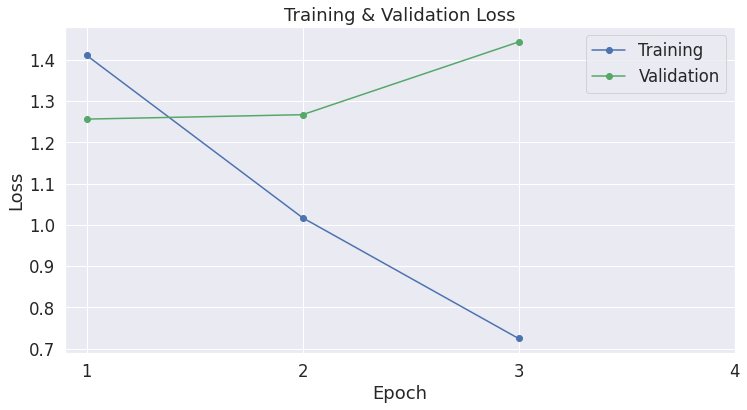

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(training_stats['Training Loss'], 'b-o', label="Training")
plt.plot(training_stats['Valid. Loss'], 'g-o', label="Validation")


# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

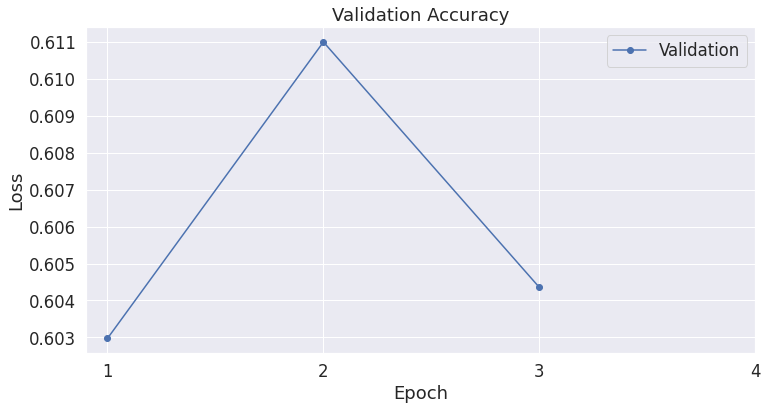

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(training_stats['Valid. Accur.'], 'b-o', label="Validation")


# Label the plot.
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Model Evaluation

In [ ]:
def validating(prediction_dataloader , model):
    """Prediction on test dataset for model evaluation
    param:prediction datasets , model to be used
    returns:output predictions and true labels for evaluation  
    rtype:np.array
    
    """

    # Put model in evaluation mode
    model.eval()

    # Tracking variables 
    predictions , true_labels = [], []

    # Predict 
    for batch in prediction_dataloader:
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Telling the model not to compute or store gradients, saving memory and speeding up prediction
      with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs[0]

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      # Store predictions and true labels
      predictions.append(logits)
      true_labels.append(label_ids)
    return predictions , true_labels

In [ ]:
predictions , true_labels=validating(prediction_dataloader , bert_model)

In [ ]:
from functools import reduce
scores = reduce(lambda x,y: x+y,[list(map(np.argmax,p)) for p in predictions])
labels = reduce(lambda x,y: list(x) + list(y), true_labels)


from sklearn.metrics import accuracy_score
print(" Accuracy " ,accuracy_score(scores, labels))


 Accuracy  0.6058286224796291


In [ ]:
import itertools
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(20, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

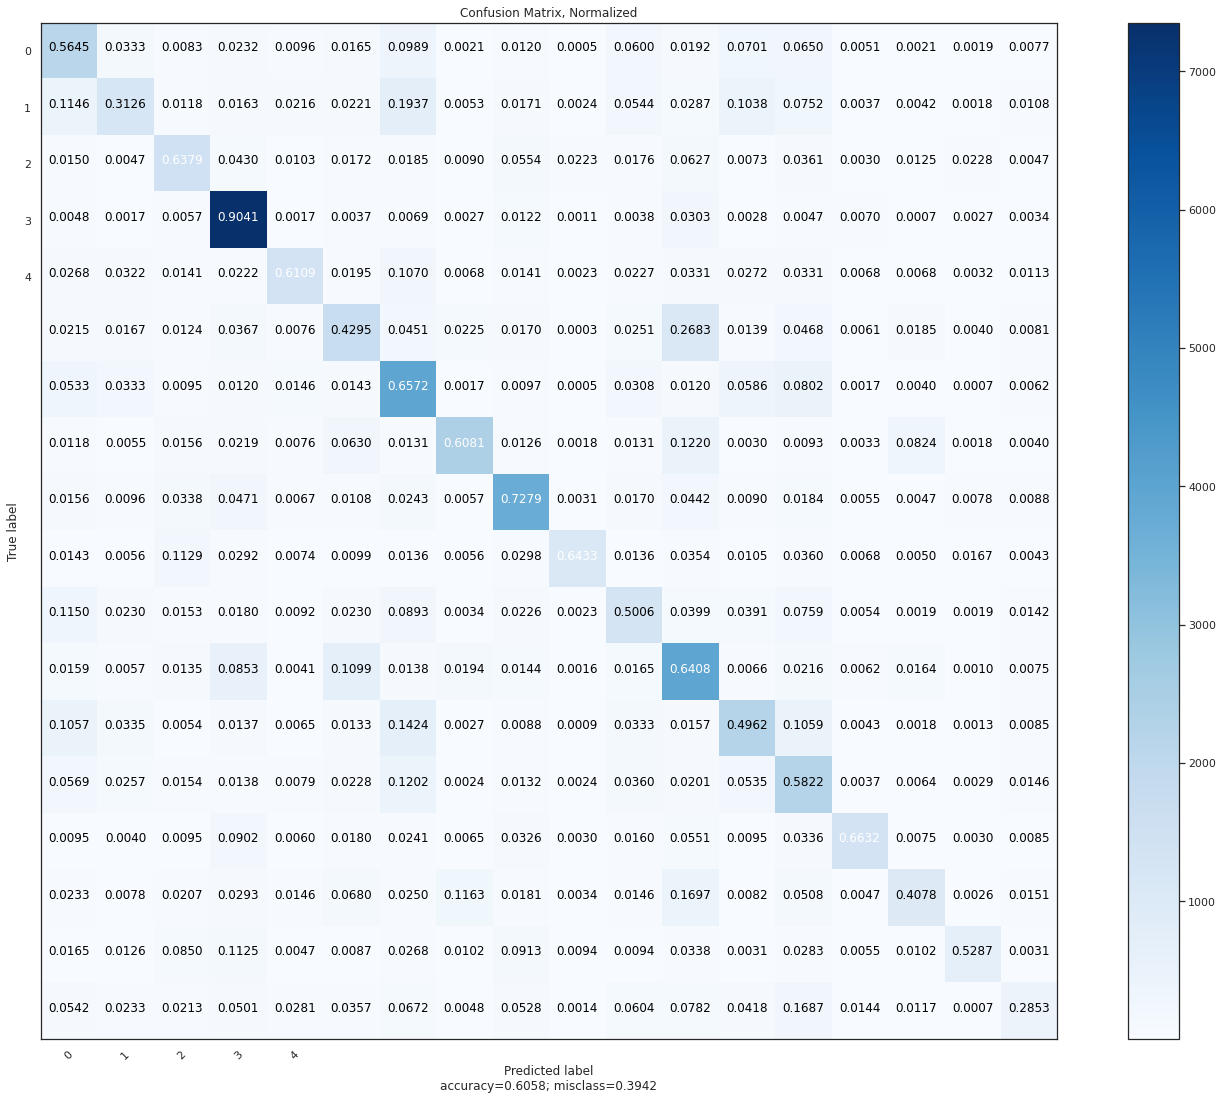

In [ ]:
from sklearn.metrics import confusion_matrix

sns.set(font_scale=1)
sns.set(style='white')


cm = confusion_matrix(labels,scores)
plot_confusion_matrix(cm           = cm, 
                      normalize    = True,
                      target_names = ['0', '1', '2','3','4'],
                      title        = "Confusion Matrix, Normalized")